In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

lim = np.array([[-5,-5],[5,5]])     
discrete_num = 50

def drawResult(F,p=[0,0]):   
    x = np.linspace(lim[0][0], lim[1][0], discrete_num) 
    y = np.linspace(lim[0][1], lim[1][1], discrete_num) 
    x,y = np.meshgrid(x,y)
    np.meshgrid()

    z = F([x,y])
    v = F(p)
    plt.contourf(x,y,z,levels=10, alpha=.75, cmap='coolwarm')
    C = plt.contour(x,y,z,levels=10)
    plt.clabel(C, inline=True, fontsize=8)
    plt.plot(p[0],p[1],'x')
    plt.text(lim[0][0]+1,lim[0][1]+1,\
             r'$f(%.4f,%.4f)=%.4f$'%(p[0],p[1],v),\
             fontdict={'size':'9','color':'b'})

    
def sample():
    return np.random.rand(2)*(lim[1] - lim[0])+lim[0]

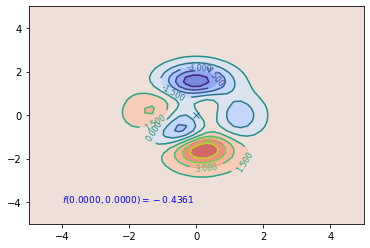

In [3]:
# minimal functions
def af(a):
    x = a[0]
    y = a[1]
    return - 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2) + \
            10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2) + \
            1/3**np.exp(-(x+1)**2 - y**2)

drawResult(af)

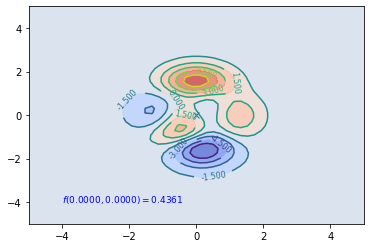

In [58]:
def F(a):
    x = a[0]
    y = a[1]
    return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)- 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2)- 1/3**np.exp(-(x+1)**2 - y**2)

drawResult(F)

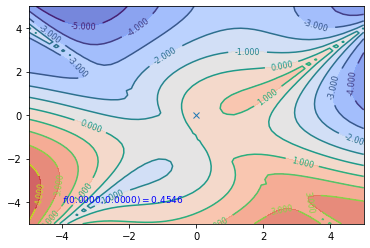

In [4]:
 def Rana(a):
    sum = 0
    for i in range(len(a)-1):
        p1 = a[i]
        p2 = a[i+1]
        sum += (p1*np.sin(np.sqrt(np.fabs(p2+1-p1)))*np.cos(np.sqrt(np.fabs(p1+p2+1)))+
                (p2+1)*np.cos(np.sqrt(np.fabs(p2+1-p1)))*np.sin(np.sqrt(np.fabs(p1+p2+1))))
    return sum

drawResult(Rana)

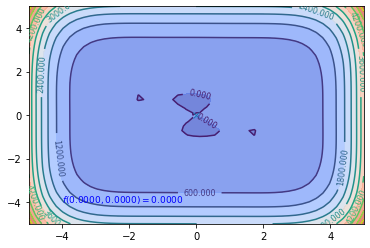

In [5]:
# global optimum x* = (0.08983,0.7126) and f(x*) = -1.0316285 for 5 < x(i) < 5
def six_hump_camel_back(a):
    return 4*a[0]**2 -2.1*a[0]**4+1/3*a[0]**6+a[0]*a[1]-4*a[1]**2+4*a[1]**4

drawResult(six_hump_camel_back)

minimal value:  -7.101898003356115


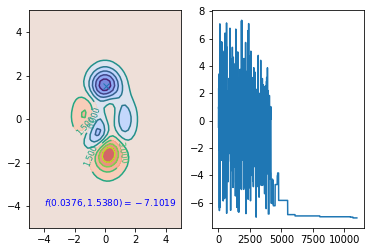

In [57]:
# SA

class SA():
    def __init__(self, prob_v, prob_p, prob_s=None, T=100, T_end=1e-3, L=100, r=0.9):
        self.T = T              
        self.T_end = T_end    
        self.L = L              
        self.r = r    

        self.f = prob_v 
        self.sample = prob_p

        self.x = self.sample()
        self.v = self.f(self.x)

        self.iter_num = 0
        # print
        self.vm = []
        self.tm = []
        if prob_s == None:
            self.drawX = print
        else:
            self.drawX = prob_s

    # def new_sample(self):
    #     return np.random.rand()*(self.lim[1] - self.lim[0])
    
    """accept new"""
    def metropolis(self, n):
        nv = self.f(n)
        dv = nv - self.v 
        if dv < 0 or np.exp(-dv/self.T) > np.random.rand():
            self.x = n
            self.v = nv

        
    def solve(self):
        while self.T > self.T_end:
            for i in range(self.L):
                n = self.sample()
                self.metropolis(n)
                self.vm.append(self.v)
            self.T *= self.r
            self.iter_num += 1
            self.tm.append(self.T)
    
    def drawValueChange(self):
        plt.subplot(1,2,1)
        self.drawX(self.f, self.x)#, self.v)
        print("minimal value: ",self.v)
        plt.subplot(1,2,2)
        plt.plot(list(range(self.iter_num*self.L)),self.vm)
        #plt.plot(np.linspace(0,self.iter_num*self.L,self.iter_num),self.tm,'r')
        plt.show()
        
sa = SA(af, sample, drawResult)
sa.solve()
sa.drawValueChange()

min_fitness: 0.001
最优的基因型： [1 0 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1
 1 1 0 0 1 0 1 1 1 0 1]
(x, y): (-0.0101950770732806, 1.5738598450338745)
最小值： -7.149854767688107


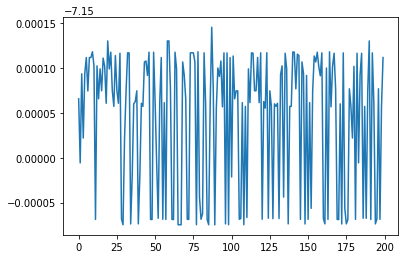

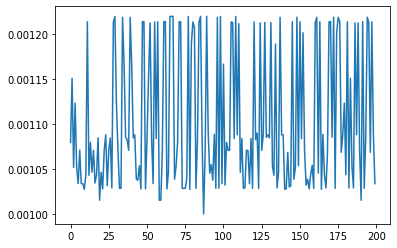

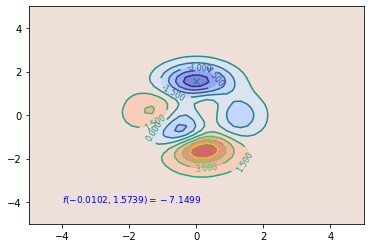

In [68]:
from mpl_toolkits.mplot3d import Axes3D

# GA
class GA():
    def __init__(self, prob_v):
        self.DNA_SIZE = 24
        self.POP_SIZE = 200
        self.CROSSOVER_RATE = 0.8
        self.MUTATION_RATE = 0.003
        self.N_GENERATIONS = 50
        self.pop = np.random.randint(2, size=(self.POP_SIZE, self.DNA_SIZE*2))
        #self.a = []
        
        self.F = prob_v
        
        plt.ion()   #将画图模式改为交互模式，程序遇到plt.show不会暂停，而是继续执行
        #plot_3d(ax)
    
    
    def solve(self):
        for i in range(self.N_GENERATIONS):
            self.a = self.translateDNA()
            self.evolve()
            self.select()
    
    def get_fitness(self):
        a = self.translateDNA()
        pred = self.F(a)
        return -(pred - np.max(pred)) + 1e-3 # avoid negtive value
    
    def translateDNA(self):
        x_pop = self.pop[:,1::2]#奇数列表示X
        y_pop = self.pop[:,::2] #偶数列表示y
        
        #pop:(POP_SIZE,DNA_SIZE)*(DNA_SIZE,1) --> (POP_SIZE,1)
        x = x_pop.dot(2**np.arange(self.DNA_SIZE)[::-1])/\
                        float(2**self.DNA_SIZE-1)*(lim[1][0]-lim[0][0])+lim[0][0]
        y = y_pop.dot(2**np.arange(self.DNA_SIZE)[::-1])/\
                        float(2**self.DNA_SIZE-1)*(lim[1][1]-lim[0][1])+lim[0][1]
        return [x,y]
    
    def evolve(self):
        new_pop = []
        for p in self.pop: # parent
            child = p
            # cross
            if np.random.rand() < self.CROSSOVER_RATE:
                p2 = self.pop[np.random.randint(self.POP_SIZE)]
                cross_point = np.random.randint(0, self.DNA_SIZE*2)
                child[cross_point:] = p2[cross_point:]
            # mutation
            if np.random.rand() < self.MUTATION_RATE:
                mutate_point = np.random.randint(0, self.DNA_SIZE*2)
                child[mutate_point] ^= 1
            new_pop.append(child)
        self.pop = np.array(new_pop)
    
    def select(self): # select good fitness, with replication
        fitness = self.get_fitness()
        idx = np.random.choice(np.arange(self.POP_SIZE), size=self.POP_SIZE, replace=True,
                           p=(fitness)/(fitness.sum()) )
        self.pop = self.pop[idx]        
        #print('select',self.pop)
        
    def print_info(self):
        fitness = self.get_fitness()
        min_fitness_index = np.argmin(fitness)
        print("min_fitness:", fitness[min_fitness_index])
        [x,y] = self.translateDNA()
        print("最优的基因型：", self.pop[min_fitness_index])
        print("(x, y):", (x[min_fitness_index], y[min_fitness_index]))
        print("最小值：", self.F([x[min_fitness_index], y[min_fitness_index]]))
        
        #print_info(pop)
        plt.ioff()
        #plot_3d(ax)
        # 目标函数变化曲线
        y1=self.F([x,y])
        y2=self.get_fitness()
        x0=list(range(len(y1)))
        plt.plot(x0,y1)
        plt.show()
        plt.plot(x0,y2)
        plt.show()
        drawResult(af,[x[min_fitness_index], y[min_fitness_index]])
                

ga = GA(af)
ga.solve()
ga.print_info()

min_fitness: 1e-15
最优的基因型： [1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1
 0 1 1 1 1 1 1 1 0 1 1]
(x, y): (0.006769597933864446, 1.559753212914062)
最小值： -7.1413447540028265


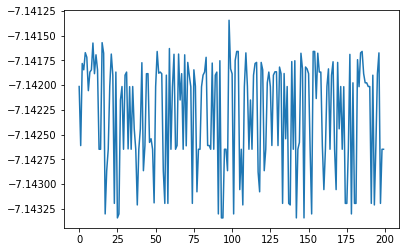

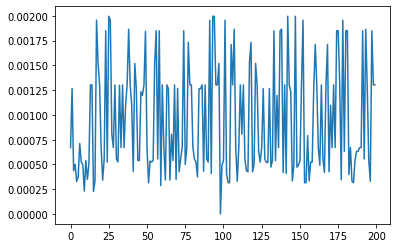

temp: 2.289734845645553e-11 3.775134544279098e-12


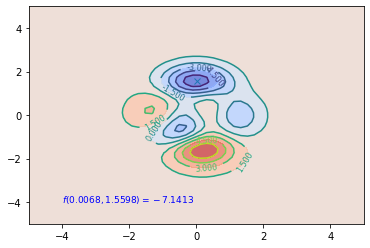

In [89]:
# GASA
# 温度控制变异概率
class GASA():
    def __init__(self, prob_v):
        self.DNA_SIZE = 24
        self.POP_SIZE = 200
        self.CROSSOVER_RATE = 0.8        
        self.MUTATION_RATE_BASE = 0.1
        self.MUTATION_RATE = self.MUTATION_RATE_BASE
        self.N_GENERATIONS = 50
        self.pop = np.random.randint(2, size=(self.POP_SIZE, self.DNA_SIZE*2))
        #self.a = []
        
        self.T = 1       
        self.r = 0.5
        
        self.F = prob_v
        
        plt.ion()   #将画图模式改为交互模式，程序遇到plt.show不会暂停，而是继续执行
        #plot_3d(ax)
    
    
    def solve(self):
        for i in range(self.N_GENERATIONS):
            self.a = self.translateDNA()
            self.evolve()
            self.select()
            self.MUTATION_RATE =self.MUTATION_RATE_BASE* self.T
            self.T = math.exp(-self.r*i)
    
    def get_fitness(self):
        a = self.translateDNA()
        pred = self.F(a)
        return -(pred - np.max(pred)) + 1e-15 # avoid negtive value
    
    def translateDNA(self):
        x_pop = self.pop[:,1::2]#奇数列表示X
        y_pop = self.pop[:,::2] #偶数列表示y
        
        #pop:(POP_SIZE,DNA_SIZE)*(DNA_SIZE,1) --> (POP_SIZE,1)
        x = x_pop.dot(2**np.arange(self.DNA_SIZE)[::-1])/\
                        float(2**self.DNA_SIZE-1)*(lim[1][0]-lim[0][0])+lim[0][0]
        y = y_pop.dot(2**np.arange(self.DNA_SIZE)[::-1])/\
                        float(2**self.DNA_SIZE-1)*(lim[1][1]-lim[0][1])+lim[0][1]
        return [x,y]
    
    def evolve(self):
        new_pop = []
        for p in self.pop: # parent
            child = p
            # cross
            if np.random.rand() < self.CROSSOVER_RATE:
                p2 = self.pop[np.random.randint(self.POP_SIZE)]
                cross_point = np.random.randint(0, self.DNA_SIZE*2)
                child[cross_point:] = p2[cross_point:]
            # mutation
            if np.random.rand() < self.MUTATION_RATE:
                mutate_point = np.random.randint(0, self.DNA_SIZE*2)
                child[mutate_point] ^= 1
            new_pop.append(child)
        self.pop = np.array(new_pop)
    
    def select(self): # select good fitness, with replication
        fitness = self.get_fitness()
        idx = np.random.choice(np.arange(self.POP_SIZE), size=self.POP_SIZE, replace=True,
                           p=(fitness)/(fitness.sum()) )
        self.pop = self.pop[idx]        
        #print('select',self.pop)
        
    def print_info(self):
        fitness = self.get_fitness()
        min_fitness_index = np.argmin(fitness)
        print("min_fitness:", fitness[min_fitness_index])
        [x,y] = self.translateDNA()
        print("最优的基因型：", self.pop[min_fitness_index])
        print("(x, y):", (x[min_fitness_index], y[min_fitness_index]))
        print("最小值：", self.F([x[min_fitness_index], y[min_fitness_index]]))
        
        #print_info(pop)
        plt.ioff()
        #plot_3d(ax)
        # 目标函数变化曲线
        y1=self.F([x,y])
        y2=self.get_fitness()
        x0=list(range(len(y1)))
        plt.plot(x0,y1)
        plt.show()
        plt.plot(x0,y2)
        plt.show()
        drawResult(af,[x[min_fitness_index], y[min_fitness_index]])
        print("temp:", self.T, self.MUTATION_RATE)
                

gasa = GASA(af)
gasa.solve()
gasa.print_info()

In [66]:
a

array([[1, 1, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1]])

In [27]:
a[:,1::2]

array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 1],
       [1, 1, 0],
       [0, 1, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [1, 1, 1],
       [0, 1, 1],
       [1, 1, 0],
       [0, 0, 1],
       [1, 0, 1]])

In [70]:
0.9 ** 50

0.00515377520732012